# Data Exploration: Measuring User Conversion

    Author: Angel He
    Date: October 18, 2021

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<u>Research questions:</u>

How many queries (reservation requests) on average does a renter place before placing an order? 
 (maybe separate how many times the renter query because item is not available vs because the renter changes their mind. may need to use additional tables)

How many queries on average before a user drops off and doesn’t rent?

- Instead of finding the number of queries on average before user places an order or drops off, I'm using number of orders divided by number of queries as a more general starting point, since to answer the original questions we would need to make sure to only count the number of unordered queries before an order, but what if a user does their first query, places an order, then does their second query but does not place an order, and does a third query and place another order? Do we count 0 or 1 query in that case? This is illustrated by renter_id 2 and item_id 74 below.



In [88]:
df_sorted[(df_sorted.renter_id==2)&(df_sorted.item_id==74)]

,date_started,date_ended,is_calendared,is_extended,is_in_cart,renter_id,item_id,charge,deposit,tax,dt_created
426,2021-08-01,2021-09-01,True,False,False,2,74,2.659562,0.664891,0.212765,2021-07-27 22:16:32.567156
392,2021-09-01,2021-09-10,False,False,False,2,74,0.937847,0.360710,0.083234,2021-08-04 23:32:25.831759
391,2021-09-01,2021-09-22,True,True,False,2,74,1.423771,0.547604,0.126360,2021-08-04 23:36:44.548886


<u>Outline:</u>

1. Import and sort data
2. Group by renter analysis
3. Group by renter & item analysis
4. Group by item analysis
5. Does price matter?
6. Possible next steps

### 1. Import and sort data

In [27]:
df=pd.read_csv('/content/drive/MyDrive/Hubbub/reservations.csv')
df

,date_started,date_ended,is_calendared,is_extended,is_in_cart,renter_id,item_id,charge,deposit,tax,dt_created
0,2021-10-04,2021-12-19,True,False,False,2756,245,44.621315,11.155329,3.960142,2021-10-02 02:47:39.199506
1,2021-10-02,2021-10-03,True,False,False,2756,325,40.192813,10.048203,3.567112,2021-10-02 02:26:05.224475
2,2021-10-02,2021-12-18,False,False,False,2756,325,40.060297,10.015074,3.555351,2021-09-30 18:09:18.070401
3,2021-09-05,2021-10-02,True,False,False,2756,81,6.275663,1.568916,0.556965,2021-09-30 18:08:48.910432
4,2021-10-02,2021-12-19,False,False,False,2756,325,40.192813,10.048203,3.567112,2021-09-30 18:07:00.441643
...,...,...,...,...,...,...,...,...,...,...,...
584,2020-09-25,2020-09-28,True,False,False,25,40,24.330000,6.080000,0.000000,2021-07-19 11:00:28.455879
585,2020-09-18,2020-09-21,True,False,False,25,41,24.330000,6.080000,0.000000,2021-07-19 11:00:27.903584
586,2020-09-19,2020-09-20,True,False,False,31,54,6.000000,1.500000,0.000000,2021-07-19 11:00:27.494878
587,2020-09-18,2020-09-20,True,False,False,5,39,22.190000,5.550000,0.000000,2021-07-19 11:00:26.904853


"reservations" - date ranges for renting items on Hubbub:

**"date_started"** (date) - the start date for the reservation

**"date_ended"** (date) - the end date for the reservation

"is_calendared" (boolean) - T/F is this reservation official/ordered, default to FALSE

"is_extended" (boolean) - T/F is this a reservation for an extension on an existing order, defaults to FALSE

"is_in_cart" (boolean) - T/F temporary state, is this item in a user's cart

"charge" (float) - how much will the rental cost the renter

"deposit" (float) - how much deposit does the renter owe to Hubbub

"tax" (float) - how much tax the renter will pay on the rental

"dt_created" (timestamp) - the datetime that the reservation was first queried, defaults to UTC timezone

**"renter_id"** (integer) - primary key to renters, the user id of the renter who booked the reservation

**"item_id"** (integer) - primary key to items, the item id of the item that is being reserved

In [28]:
# sort by renter_id, item_id, count how many 
df_sorted=df.sort_values(by=['renter_id','item_id','dt_created'])
df_sorted.head()

,date_started,date_ended,is_calendared,is_extended,is_in_cart,renter_id,item_id,charge,deposit,tax,dt_created
450,2021-07-22,2021-07-31,False,False,False,1,15,13.165922,3.291481,1.053274,2021-07-20 23:28:14.510201
402,2021-08-12,2021-08-28,False,False,False,1,15,14.299666,3.574916,1.269095,2021-08-01 09:11:08.852195
399,2021-08-12,2021-08-26,False,False,False,1,24,13.368779,3.342195,1.186479,2021-08-01 09:38:39.521291
398,2021-08-12,2021-08-28,False,False,False,1,24,14.299666,3.574916,1.269095,2021-08-01 09:40:12.416437
403,2021-08-04,2021-08-19,False,False,False,1,52,3.921389,0.980347,0.348023,2021-08-01 08:06:49.678319


In [54]:
# check whether order is always placed on the last query of a user for an item
# with pd.option_context("display.max_rows", None): 
#   display(df_sorted)
# (rules: if is_calendared is True is the last one for the user&item, then the order must be the last time the user queries for the item
# if is_calendared is True not for the last one for the user&item, then ... (is this very important?) )
# skip for now bc seems unlikely a user would query, order, and query again in the same session

### 2. Group by renter analysis

In [40]:
dfgrp2=pd.DataFrame(df_sorted.groupby(by=['renter_id']).sum()['is_calendared'])
dfgrp2=dfgrp2.join(pd.DataFrame(df_sorted.groupby(by=['renter_id']).size())) # join with num times queried per user per item
dfgrp2.columns=['num_calendared','num_queried']

In [41]:
dfgrp2

,num_calendared,num_queried
renter_id,,
1,0,13
2,2,6
4,0,1
5,2,2
7,4,9
...,...,...
2789,0,1
2790,2,3
2791,0,1


In [42]:
# ratio: num_calendared/num_queried
dfgrp2['num_calendared/num_queried']=dfgrp2.num_calendared/dfgrp2.num_queried
dfgrp2

,num_calendared,num_queried,num_calendared/num_queried
renter_id,,,
1,0,13,0.000000
2,2,6,0.333333
4,0,1,0.000000
5,2,2,1.000000
7,4,9,0.444444
...,...,...,...
2789,0,1,0.000000
2790,2,3,0.666667
2791,0,1,0.000000


In [43]:
dfgrp2.describe() # 

,num_calendared,num_queried,num_calendared/num_queried
count,149.000000,149.000000,149.000000
mean,1.610738,3.953020,0.583202
std,1.711296,4.459026,0.411129
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.166667
50%,1.000000,2.000000,0.500000
75%,2.000000,6.000000,1.000000
max,8.000000,23.000000,1.000000


(array([33.,  5.,  5., 11.,  5., 19.,  4.,  0.,  2., 65.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

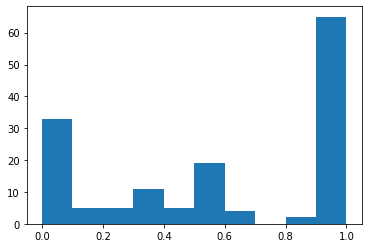

In [45]:
plt.hist(dfgrp2['num_calendared/num_queried'])

In [49]:
65/149,33/149 # 43.6% users order on their first query or every time they query, 22.1% users never ordered

(0.436241610738255, 0.2214765100671141)

**43.6% users order on their first query or every time they query, 22.1% users never ordered**

### 3. Group by renter & item analysis

In [31]:
dfgrp=pd.DataFrame(df_sorted.groupby(by=['renter_id','item_id']).sum()['is_calendared']) # num times calendared per renter per item
dfgrp

is_calendared
renter_id item_id               
1         15                   0
          24                   0
          52                   0
          138                  0
          140                  0
...                          ...
2790      205                  1
2791      15                   0
2793      206                  1
2794      15                   0
          29                   0

[450 rows x 1 columns]

In [32]:
dfgrp=dfgrp.join(pd.DataFrame(df_sorted.groupby(by=['renter_id','item_id']).size())) # join with num times queried per user per item
dfgrp.columns=['num_calendared','num_queried']
dfgrp

num_calendared  num_queried
renter_id item_id                             
1         15                    0            2
          24                    0            2
          52                    0            3
          138                   0            1
          140                   0            1
...                           ...          ...
2790      205                   1            2
2791      15                    0            1
2793      206                   1            1
2794      15                    0            1
          29                    0            1

[450 rows x 2 columns]

In [47]:
dfgrp['num_calendared/num_queried']=dfgrp.num_calendared/dfgrp.num_queried
dfgrp

num_calendared  num_queried  num_calendared/num_queried
renter_id item_id                                                         
1         15                    0            2                         0.0
          24                    0            2                         0.0
          52                    0            3                         0.0
          138                   0            1                         0.0
          140                   0            1                         0.0
...                           ...          ...                         ...
2790      205                   1            2                         0.5
2791      15                    0            1                         0.0
2793      206                   1            1                         1.0
2794      15                    0            1                         0.0
          29                    0            1                         0.0

[450 rows x 3 columns]

In [48]:
dfgrp.describe()

,num_calendared,num_queried,num_calendared/num_queried
count,450.000000,450.000000,450.000000
mean,0.533333,1.308889,0.445963
std,0.577993,0.693695,0.474025
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000
max,3.000000,6.000000,1.000000


(array([226.,   0.,   4.,   5.,   1.,  32.,   1.,   0.,   0., 181.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

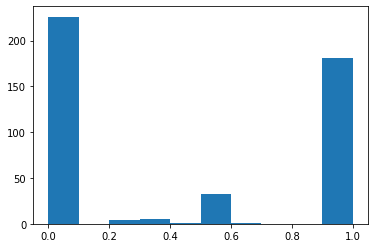

In [50]:
plt.hist(dfgrp['num_calendared/num_queried'])

In [51]:
181/450,226/450 # 40.2% users order an item on the first query or every time they query, 50.2% users never ordered an item they queried

(0.4022222222222222, 0.5022222222222222)

**40.2% users order an item on the first query or every time they query for that item, 50.2% users never ordered an item they queried**

In [67]:
###
# later: what % instances do users query without ordering bc dates are not available? ie. how many queries were invalid? if high, then perhaps some items are popular with unmet demand 
# also, would people not order because of price?
# would need orders table to get res_date_start & res_date_end?

### 4. Group by item analysis

In [78]:
# any trends with item id and num_calendared/num_queried?
# group by item id
dfgrp3=pd.DataFrame(df_sorted.groupby(by=['item_id']).sum()['is_calendared']) # num times calendaredper item
dfgrp3=dfgrp3.join(pd.DataFrame(df_sorted.groupby(by=['item_id']).size())) # join with num times queried per item
dfgrp3.columns=['num_calendared','num_queried']
dfgrp3['num_calendared/num_queried']=dfgrp3.num_calendared/dfgrp3.num_queried
dfgrp3

,num_calendared,num_queried,num_calendared/num_queried
item_id,,,
1,1,2,0.500000
2,1,1,1.000000
3,1,2,0.500000
4,1,8,0.125000
7,2,6,0.333333
...,...,...,...
331,1,1,1.000000
332,1,2,0.500000
334,0,3,0.000000


In [79]:
dfgrp3.describe()

,num_calendared,num_queried,num_calendared/num_queried
count,177.000000,177.000000,177.000000
mean,1.355932,3.327684,0.631100
std,0.861342,3.544357,0.370666
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.333333
50%,1.000000,2.000000,0.555556
75%,2.000000,4.000000,1.000000
max,5.000000,21.000000,1.000000


(array([16., 11., 15., 13.,  7., 29.,  4.,  0.,  1., 81.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

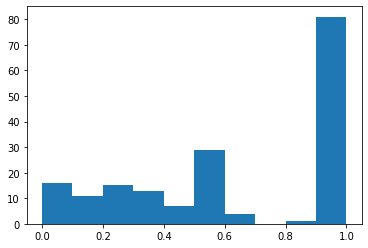

In [80]:
plt.hist(dfgrp3['num_calendared/num_queried'])

In [81]:
81/177, 16/177 # 45.7% items are ordered the first time someone queries it, 9% items are never ordered

(0.4576271186440678, 0.0903954802259887)

**45.7% items are ordered the first time someone queries it, 9% items are never ordered, the rest are somewhere inbetween**

In [99]:
# item id sorted by how good they are in terms of num_calendared/num_queried & num_queried
with pd.option_context("display.max_rows", None): 
  display(dfgrp3.sort_values(['num_calendared/num_queried','num_queried'],ascending=[False,True]))

,num_calendared,num_queried,num_calendared/num_queried,avg_charge
item_id,,,,
2,1,1,1.000000,14.350000
9,1,1,1.000000,13.290000
13,1,1,1.000000,9.220000
23,1,1,1.000000,13.700000
37,1,1,1.000000,100.090000
40,1,1,1.000000,24.330000
41,1,1,1.000000,24.330000
44,1,1,1.000000,3.020000
45,1,1,1.000000,54.450000


### 5. Does price matter?

In [89]:
dfgrp2=dfgrp2.join(pd.DataFrame(df_sorted.groupby(by=['renter_id']).mean()['charge']))
dfgrp2.rename(columns={"charge": "avg_charge"},inplace=True)
dfgrp2

,num_calendared,num_queried,num_calendared/num_queried,avg_charge
renter_id,,,,
1,0,13,0.000000,21.050791
2,2,6,0.333333,13.660513
4,0,1,0.000000,17.032592
5,2,2,1.000000,22.190000
7,4,9,0.444444,38.834236
...,...,...,...,...
2789,0,1,0.000000,58.584275
2790,2,3,0.666667,13.548354
2791,0,1,0.000000,56.361428


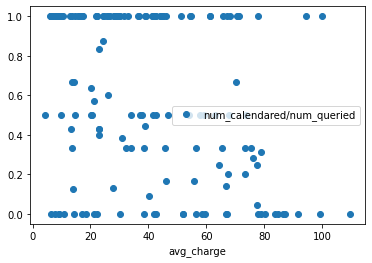

In [90]:
dfgrp2.plot(x='avg_charge', y='num_calendared/num_queried', style='o')

In [91]:
dfgrp2.avg_charge.corr(dfgrp2['num_calendared/num_queried'])

-0.29813802378726517

In [92]:
dfgrp=dfgrp.join(pd.DataFrame(df_sorted.groupby(by=['renter_id','item_id']).mean()['charge']))
dfgrp.rename(columns={"charge": "avg_charge"},inplace=True)

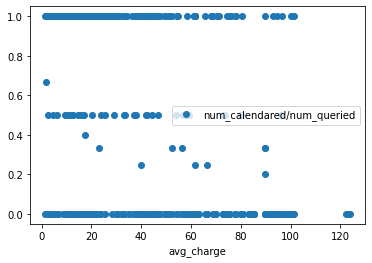

In [93]:
dfgrp.plot(x='avg_charge', y='num_calendared/num_queried', style='o')

In [94]:
dfgrp.avg_charge.corr(dfgrp['num_calendared/num_queried'])

-0.43844707443936726

In [ ]:
dfgrp3=dfgrp3.join(pd.DataFrame(df_sorted.groupby(by=['item_id']).mean()['charge']))
dfgrp3.rename(columns={"charge": "avg_charge"},inplace=True)
dfgrp3

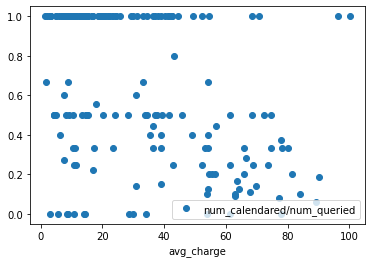

In [83]:
dfgrp3.plot(x='avg_charge', y='num_calendared/num_queried', style='o')

In [84]:
dfgrp3.avg_charge.corr(dfgrp3['num_calendared/num_queried'])

-0.3993556459430068

**In all three groupby cases, the correlation between average charge of query and the num_calendared/num_queried ratio is negative but not very high. The negative relationship is strongest on the user & item level (-0.438) and weakest on the user only level (-0.298).** This may suggest that users have different budgets for renting, hence the impact of price differs from person to person and the user-level correlation is not as strong, whereas when we look at user & item the correlation gets stronger, because for a particular user they are more likely to order something if the price is good.

### 6. Possible next steps

Try to determine the cause of people not ordering when they query. For example, how many cases are due to the item being rented out and not available during the query time frame, how many cases are due to the price being too high, and how many cases are just user exploring? Would likely need the orders table to check reservation start and end dates with the queried ones. If the number of cases due to item not available is high, that may suggest some items are popular and there is unmet demand.